# Notebook expérimental
## Mars Express Data Driven Digital Twin
---


Problème principal : "Kernel died" **au moment du sort by date** à cause de la RAM si on prend **l'année martienne entière** (~ 2008-2010) ce qui correspond au tri d'environ **3 millions de lignes**

Pour les mêmes raisons de limite de RAM on effectue nos prédictions que sur une seule des 33 variables *power*

*Note : On s'y prend peut être mal pour la partie interpolation. On veut d'abord interpoler/échantillonner tout le monde sur le niveau le plus fin pour ensuite appliquer notre filtre de sous-échantillonage que l'on veut (par h, par 30min ...)*

---
D'après nos tests sur la limite de RAM de nos pc on a pu voir que :
* Avec 4 mois de données seulement, on obtient des résultats aberrants avec une régression linéaire, comme on te l'a expliqué par mail 
* Avec 1 année terrestre (quasi limite pour la RAM) on a quelque chose de plus sympa, on retrouve effectivement les effets de périodicité que tu as cité dans le mail, invisibles sur 4 mois.
---



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import models, layers, initializers

In [2]:
TRAIN_FOLDER = "../data_MEX/train_set/"
TEST_FOLDER = "../data_MEX/test_set/"

In [41]:

def import_file(file_name, file_type):
    data = pd.read_csv(file_name, sep=",", index_col=0) # index -> ut_ms
    data.index = pd.to_datetime(data.index, unit='ms') # ut_ms -> datetime

    if file_type == "dmop":
        data['commande'] = data.apply(lambda x : x['subsystem'][:4], axis=1)
        #data['len'] = data.apply(lambda x : len(x['subsystem'].split(".")), axis=1)
        data = pd.get_dummies(data[["commande"]]) #One Hot Encoding (naïf)
        data = data.resample('60min').pad()

    elif file_type == "ftl":
        data = pd.get_dummies(data[["type", "flagcomms"]]) #One Hot Encoding (naïf)
        data["flagcomms"] = data["flagcomms"].astype(int) # Passer les true/false en 1/0
        data = data.resample('60min').pad()
    else:
        data = data.resample('60min').mean()
    return data


## import de la première année d'une classe de variables quantitative (saaf, ltdata)
def import_all_files(folder, file_types, verbose):
    
    """
    Import all files for one martian year and apply specific preprocessing regarding variable types in the file.
    Return a list of DataFrames
    """
    
    df_list = []
    for file_type in file_types:
        print('Importing', file_type, "data ...") if verbose else 0
        query = f"{folder}*{file_type}*"
        file_name_list = glob.glob(query) 
        if len(file_name_list) > 1 :
            file_name_list_sorted = np.sort(file_name_list)
            df_3years = []
            for file_name in file_name_list_sorted:
                print('>', file_name) if verbose else 0
                data = import_file(file_name, file_type)
                df_3years.append(data)

            data = pd.concat(df_3years)
        else : 
            file_name = file_name_list[0]
            print('>', file_name) if verbose else 0
            data = import_file(file_name, file_type)
        df_list.append(data)
        print("Done.") if verbose else 0

    return df_list
    

def interpolate(df_list, verbose):
    """
    Concatenate a list of DataFrames, sort by date and interpolate (linearly or pad interpolation.
    """
    
    print("Concatenating ...") if verbose else 0
    combined = pd.concat(df_list, axis=1, sort=False)
    print(f"-> Concatenate done, {len(combined)} rows.\n Sort by date ...")if verbose else 0
    #combined = combined.sort_values("date").reset_index(drop=True)
    print("-> Sort done")if verbose else 0
    col = list(combined.columns)
    print("Interpolating ...")if verbose else 0
    for c in col:
        if c.split('_')[0] == "type" or c == "flagcomms" or c == "commande" : #categorical data
            combined[c] = combined[c].interpolate(method="ffill")
        else : #quantitative data
            combined[c] = combined[c].interpolate(method="linear")
    print("Data interpolated")if verbose else 0
    print("Traitement des NaN")if verbose else 0
    combined = combined.fillna(method ="bfill")
    combined.dropna(inplace=True)
    print("Done.")if verbose else 0

    return combined

def generate_data(train_folder, test_folder, verbose):
    
    file_types = ["saaf", "dmop", "ltdata", "ftl"]
    
    print("@@@@@@"*4) if verbose else 0
    print("Creating train dataset") if verbose else 0
    print("@@@@@@"*4) if verbose else 0
    df_list_train = import_all(train_folder, ["power"] + file_types, verbose)
    print("@@@@@@"*4) if verbose else 0
    print("Creating test dataset") if verbose else 0
    print("@@@@@@"*4) if verbose else 0
    df_list_test = import_all(test_folder, file_types, verbose)
    
    print("@@@@@@"*4) if verbose else 0
    print("Interpolating train dataset") if verbose else 0
    print("@@@@@@"*4) if verbose else 0
    train = interpolate(df_list_train, verbose) 
    print("@@@@@@"*4) if verbose else 0
    print("Interpolating test dataset") if verbose else 0
    print("@@@@@@"*4) if verbose else 0
    test = interpolate(df_list_test, verbose)
    
    to_del_test = np.setdiff1d(test.columns, train.columns[33:])
    to_del_train = np.setdiff1d(train.columns[33:],test.columns)
    test.drop(to_del_test, inplace=True, axis=1)
    train.drop(to_del_train, inplace=True, axis=1)
    return train, test

def import_data():
    train = pd.read_pickle('train.p')
    test = pd.read_pickle('test.p')
    return train, test
    
def generate_train_data():
    train, test = import_data()

    power_ids = train.columns[train.columns.str.match("NPWD")]
    X = train.copy()
    X.drop(list(power_ids), inplace = True, axis = 1) # drop power
    print(np.shape(X))
    y = train.copy()[list(power_ids)]
    print(np.shape(y))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

    return X_train, X_test, y_train, y_test



In [25]:
verbose = True
train, test = generate_data(TRAIN_FOLDER, TEST_FOLDER, verbose)

@@@@@@@@@@@@@@@@@@@@@@@@
Creating train dataset
@@@@@@@@@@@@@@@@@@@@@@@@
Importing power data ...
> ../data_MEX/train_set/power--2008-08-22_2010-07-10.csv
> ../data_MEX/train_set/power--2010-07-10_2012-05-27.csv
> ../data_MEX/train_set/power--2012-05-27_2014-04-14.csv
Done.
Importing saaf data ...
> ../data_MEX/train_set/context--2008-08-22_2010-07-10--saaf.csv
> ../data_MEX/train_set/context--2010-07-10_2012-05-27--saaf.csv
> ../data_MEX/train_set/context--2012-05-27_2014-04-14--saaf.csv
Done.
Importing dmop data ...
> ../data_MEX/train_set/context--2008-08-22_2010-07-10--dmop.csv
> ../data_MEX/train_set/context--2010-07-10_2012-05-27--dmop.csv
> ../data_MEX/train_set/context--2012-05-27_2014-04-14--dmop.csv
Done.
Importing ltdata data ...
> ../data_MEX/train_set/context--2008-08-22_2010-07-10--ltdata.csv
> ../data_MEX/train_set/context--2010-07-10_2012-05-27--ltdata.csv
> ../data_MEX/train_set/context--2012-05-27_2014-04-14--ltdata.csv
Done.
Importing ftl data ...
> ../data_MEX/train

In [42]:
X_train, X_test, y_train, y_test = generate_train_data()


(49464, 51)
(49464, 33)


In [43]:
print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(y_train))
print(np.shape(y_test))

(39571, 51)
(9893, 51)
(39571, 33)
(9893, 33)


In [47]:
from sklearn.linear_model import LinearRegression
import seaborn as sns

reg = LinearRegression().fit(X_train, y_train)
predict = reg.predict(X_test)


In [56]:
y = y_test.iloc[:,0]

In [54]:
y_hat = predict[:,0]

In [67]:
np.abs(y_test-predict)/y_test)

,NPWD2372,NPWD2401,NPWD2402,NPWD2451,NPWD2471,NPWD2472,NPWD2481,NPWD2482,NPWD2491,NPWD2501,...,NPWD2792,NPWD2801,NPWD2802,NPWD2821,NPWD2851,NPWD2852,NPWD2871,NPWD2872,NPWD2881,NPWD2882
ut_ms,,,,,,,,,,,,,,,,,,,,,
2011-11-09 17:00:00,0.248850,2.345617,0.002225,0.534470,0.026746,0.195428,0.488021,2.140953,0.026992,0.026688,...,0.042015,0.034207,0.162269,0.034487,0.356963,0.034930,0.036207,0.034112,1.566477,0.036796
2009-05-16 05:00:00,0.223043,0.038954,0.003137,0.149089,0.032129,0.307178,4.342755,0.015948,0.025283,0.089090,...,0.200602,0.020174,1.277014,0.009831,1.105098,0.036038,0.033932,0.023696,7.717030,0.017127
2013-08-02 13:00:00,0.077735,1.131355,0.000906,0.255767,0.009197,0.095349,20.440091,0.954436,0.071235,0.071344,...,0.294387,0.007671,0.259643,0.008012,0.127003,0.009600,0.000497,0.009024,0.455702,0.003722
2010-07-17 06:00:00,0.034019,0.378947,0.002431,1.059197,0.009934,0.560659,0.060172,0.332891,0.187113,0.008798,...,0.512585,0.004411,2.537974,0.005192,0.315289,0.027231,0.047195,0.013215,0.785028,0.013321
2009-10-23 20:00:00,0.274103,0.947298,0.000720,0.197153,0.015605,0.406755,5.818445,0.798112,0.090211,0.019074,...,0.255985,0.005658,0.518537,0.006723,0.227449,0.011090,0.014959,0.013206,0.805063,0.001161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-07-10 19:00:00,0.143741,1.404163,0.003453,0.058083,0.006244,0.284254,6.808926,1.147211,0.200843,0.122611,...,0.243037,0.002031,0.301341,0.002765,0.255317,0.029528,0.018247,0.023410,1.671742,0.008624
2008-11-26 19:00:00,0.020387,0.346457,0.003344,0.401725,0.012255,0.741768,7.780981,0.368500,0.069624,0.049417,...,0.593524,0.000392,0.119126,0.015020,37.733364,0.019608,0.010601,0.023823,1.767008,0.015417
2014-03-08 00:00:00,0.304758,0.212143,0.005011,0.027397,0.011807,0.560742,4.020503,0.139788,0.287096,0.021579,...,0.208813,0.017559,0.498411,0.015089,0.002989,0.037099,0.018039,0.027261,0.109573,0.021179


In [46]:
# X_train.columns[np.argsort(-reg.coef_)]

<ipython-input-46-dc5832ea14d9>:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X_train.columns[np.argsort(-reg.coef_)]


array([['commande_APSF', 'commande_MOCS', 'commande_PENS', ...,
        'type_D2PLND', 'type_D8PLTP', 'type_D7PLTS'],
       ['type_D1PVMC', 'type_D3POCM', 'type_D8PLTP', ...,
        'commande_MOCS', 'commande_PENE', 'commande_PENS'],
       ['commande_PDNE', 'type_D2PLND', 'type_D9PSPO', ...,
        'type_D8PLTP', 'type_INERTIAL', 'commande_PPNE'],
       ...,
       ['commande_PDNE', 'type_D7PLTS', 'commande_AVVV', ...,
        'commande_PPNE', 'type_D4PNPO', 'type_D1PVMC'],
       ['commande_ATTT', 'commande_SCMN', 'type_D9PSPO', ...,
        'type_D2PLND', 'type_ACROSS_TRACK', 'type_D3POCM'],
       ['commande_PDNE', 'type_D7PLTS', 'type_D8PLTP', ...,
        'type_D4PNPO', 'type_WARMUP', 'type_D1PVMC']], dtype=object)

array([<AxesSubplot:xlabel='ut_ms'>, <AxesSubplot:xlabel='ut_ms'>,
       <AxesSubplot:xlabel='ut_ms'>, <AxesSubplot:xlabel='ut_ms'>],
      dtype=object)

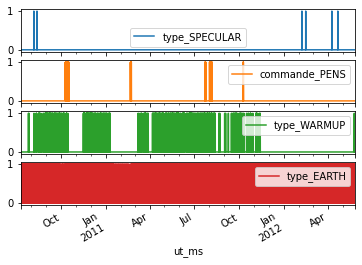

In [213]:
data[['type_SPECULAR', 'commande_PENS', 'type_WARMUP', 'type_EARTH',]].plot(subplots=True)

In [23]:
sns.regplot(y_test,predict)

ValueError: regplot inputs must be 1d

In [17]:
rmse(y_test, predict)

0.22717466989266502

<AxesSubplot:xlabel='NPWD2451'>

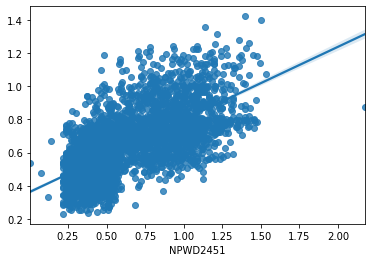

In [24]:
sns.regplot(y_test.iloc[:,3],predict[:,3])

In [137]:
np.sum((y_test.iloc[:,0] - predict[:,0])**2)

17.309647783524213

In [25]:
from metrics import rmse
err = []
for i in range(len(power_ids)):
    err.append(np.mean((y_test.iloc[:,i] - predict[:,i])**2)/ np.mean(predict[:,i]))
    
err = np.sqrt(1/33 * np.mean(err))
print(err)


0.03598544125133828


In [174]:
np.sqrt(np.mean((y_test.iloc[:,0] - predict[:,0])**2) / np.mean(predict[:,0]))

0.08690738876308982